# ML Hands-on Challenge - Data preparation and exploration

This notebook contains the N-gram count model for the ML Hands-on Challenge. The N-gram count model is a simple model that counts the number of occurrences of each N-gram in the training data and uses these counts to predict the protein structure CATH class. The N-gram count model is a simple baseline model that can be used to compare the performance of more complex models.

## Loading things

In [1]:
import pandas as pd
import numpy as np
import sys
import glob
import os
import Bio.PDB.PDBParser
import py3Dmol
import warnings
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore", message="Used element '.' for Atom")

# Get parent directory and add src/ to pythonpath
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

from src.config import CONSTANTS
from src.pdb import *

DATA_HOME = os.path.join(parent_dir, CONSTANTS.DATA_HOME)
SEED = CONSTANTS.SEED
architecture_names = CONSTANTS.ARCHITECTURE_NAMES

## Loading processed data from the [`data_prep_exploration.ipynb`](./data_prep_exploration.ipynb) notebook

In [2]:
# Open the training data sequences and structure
proc_data = pd.read_csv(f"{DATA_HOME}/data_processed.csv", index_col=0)

# Converting `piece_edges` and `domain_edges` into a proper format
proc_data = proc_data.assign(
    **{
        "piece_edges": proc_data["piece_edges"].apply(eval),
        "domain_edges": proc_data["domain_edges"].apply(eval),
    }
)

# Converting `target` to string format
proc_data["target"] = proc_data["target"].astype(str)
display(proc_data)

# Get the schema of the data
proc_data.info()

,cath_id,pdb_id,class,architecture,topology,superfamily,resolution_in_angstroms,sequence,piece_edges,num_residues,domain_edges,total_num_residues,num_gaps,target
0,2w3sB01,2w3s,3,90,1170,50,2.60,SVGKPLPHDSARAHVTGQARYLDDLPCPANTLHLAFGLSTEASAAI...,"[(2, 124)]",123,"[2, 124]",123,0,3.9
1,3be3A00,3be3,2,30,30,320,2.04,QDFRPGVYRHYKGDHYLALGLARADETDEVVVVYTRLYARAGLPST...,"[(6, 49), (51, 81)]",75,"[6, 81]",76,1,2.3
2,3zq4C03,3zq4,3,10,20,580,3.00,DIGNIVLRDRRILSEEGLVIVVVSIDMDDFKISAGPDLISRGFVIN...,"[(449, 492), (501, 555)]",99,"[449, 555]",107,1,3.1
3,1peqA03,1peq,1,10,1650,20,2.80,DITFRLAKENAQMALFSPYDIQRRYGKPFGDIAISERYDELIADPH...,"[(294, 346)]",53,"[294, 346]",53,0,1.1
4,1bdoA00,1bdo,2,40,50,100,1.80,EISGHIVRSPMVGTFYRTPSPDAKAFIEVGQKVNVGDTLCIVEAMK...,"[(77, 156)]",80,"[77, 156]",80,0,2.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6263,2yyiA02,2yyi,2,40,110,10,1.66,ATTHALTNPQVNRARPPSGQPDPYIPVGVVKQTEKGIVVRGARMTA...,"[(139, 196), (199, 266)]",126,"[139, 266]",128,1,2.4
6264,4mo0A00,4mo0,3,30,780,10,2.10,EQKIKIYVTKRRFGKLMTIIEGFDTSVIDLKELAKKLKDICACGGT...,"[(24, 102)]",79,"[24, 102]",79,0,3.3
6265,1vq8X00,1vq8,3,10,440,10,2.20,ERVVTIPLRDARAEPNHKRADKAMILIREHLAKHFSVDEDAVRLDP...,"[(7, 88)]",82,"[7, 88]",82,0,3.1
6266,1ze3D00,1ze3,3,10,20,410,1.84,DLYFNPRFLLSRFENGQELPPGTYRVDIYLNNGYMATRDVTFNTGD...,"[(1, 9), (19, 125)]",116,"[1, 125]",125,1,3.1


<class 'pandas.core.frame.DataFrame'>
Index: 6268 entries, 0 to 6267
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cath_id                  6268 non-null   object 
 1   pdb_id                   6268 non-null   object 
 2   class                    6268 non-null   int64  
 3   architecture             6268 non-null   int64  
 4   topology                 6268 non-null   int64  
 5   superfamily              6268 non-null   int64  
 6   resolution_in_angstroms  6268 non-null   float64
 7   sequence                 6268 non-null   object 
 8   piece_edges              6268 non-null   object 
 9   num_residues             6268 non-null   int64  
 10  domain_edges             6268 non-null   object 
 11  total_num_residues       6268 non-null   int64  
 12  num_gaps                 6268 non-null   int64  
 13  target                   6268 non-null   object 
dtypes: float64(1), int64(7), obje

## Calculate the counts of n-grams

We will calculate the counts of n-grams in the available data. Please note the following considerations:

- We will set `N=2`, i.e. we will calculate the counts of **bigrams**
- We will take into consideration the gaps in data but abrupting the counts there
- There could be a situation where a bigram is not present in the sequence piece (e.g. unigram) - we will drop those records

### Helper functions

In [4]:
def calculate_ngram_count(sequence, n):
    """
    Calculates the count of n-grams in a given sequence.

    Args:
        sequence (str): The input sequence.
        n (int): The length of the n-grams.

    Returns:
        dict: A dictionary containing the n-grams as keys and their counts as values.
    """
    ngram_count = {}
    for i in range(len(sequence) - n + 1):
        ngram = sequence[i : i + n]
        if ngram in ngram_count:
            ngram_count[ngram] += 1
        else:
            ngram_count[ngram] = 1
    return ngram_count


def create_sequence_set(seq, edges):
    """
    This is a helper function that takes the sequence e.g. "ABCDEFG" and a list of edges [(0, 2), (2, 4)]
    and returns a list of sequences ["AB", "CD", "EF"]

    Parameters:
        seq (str): The input sequence.
        edges (list): A list of edges representing the start and end indices of subsequences in the input sequence.

    Returns:
        list: A list of subsequences extracted from the input sequence based on the provided edges.
    """

    return [seq[edge[0] : edge[1] + 1] for edge in edges]


def process_row(row, n):
    """
    This is a helper function that takes a row of the dataframe and based on `sequence` and `piece_edges`,
    calculates the sequence set, and then calculates the ngram count for each sequence in the sequence set.
    The n-gram count is then aggregated (summed) into a single dictionary and returned.

    Args:
        row (_type_): _description_
    """

    offset = row["piece_edges"][0][0]
    piece_edges_without_offset = [
        (edge[0] - offset, edge[1] - offset) for edge in row["piece_edges"]
    ]

    sequence = row["sequence"]
    sequence_set = create_sequence_set(sequence, piece_edges_without_offset)
    ngram_count = {}
    for seq in sequence_set:
        ngram_count_seq = calculate_ngram_count(seq, n=n)
        ngram_count = {
            k: ngram_count.get(k, 0) + ngram_count_seq.get(k, 0)
            for k in set(ngram_count) | set(ngram_count_seq)
        }
    return {f"count_{k}": v for k, v in ngram_count.items()}

Now we are ready to calculate the counts! We will not forget to normalize the counts by the total number of bigrams in the dataset.

In [5]:
N = 2
count_df = pd.DataFrame.from_records(
    proc_data.apply(lambda row: process_row(row, N), axis=1)
)

# Filling missing values with 0
count_df.fillna(0, inplace=True)

# Normalize the count_df
count_df = count_df.div(count_df.sum(axis=1), axis=0)

count_df

,count_LP,count_ND,count_VI,count_SH,count_KA,count_LS,count_PI,count_YL,count_FV,count_RI,...,count_FC,count_RM,count_MC,count_WC,count_YH,count_NC,count_HC,count_NM,count_WM,count_CW
0,0.024590,0.008197,0.008197,0.008197,0.008197,0.008197,0.008197,0.008197,0.008197,0.016393,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.013889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013889,0.000000,0.013889,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.011236,0.000000,0.011236,0.000000,0.000000,0.011236,0.011236,0.000000,0.011236,0.011236,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.012658,0.000000,0.025316,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6263,0.008197,0.000000,0.008197,0.000000,0.000000,0.008197,0.000000,0.000000,0.008197,0.000000,...,0.0,0.008197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6264,0.000000,0.000000,0.012821,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6265,0.000000,0.000000,0.000000,0.000000,0.012346,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6266,0.009524,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009524,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Great! Now let's append this to the main dataframe.

In [6]:
# Concatenating the processed data and the count dataframe, dropping unigrams
master_df = pd.concat([proc_data, count_df], axis=1).dropna(axis="rows")

master_df

,cath_id,pdb_id,class,architecture,topology,superfamily,resolution_in_angstroms,sequence,piece_edges,num_residues,...,count_FC,count_RM,count_MC,count_WC,count_YH,count_NC,count_HC,count_NM,count_WM,count_CW
0,2w3sB01,2w3s,3,90,1170,50,2.60,SVGKPLPHDSARAHVTGQARYLDDLPCPANTLHLAFGLSTEASAAI...,"[(2, 124)]",123,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3be3A00,3be3,2,30,30,320,2.04,QDFRPGVYRHYKGDHYLALGLARADETDEVVVVYTRLYARAGLPST...,"[(6, 49), (51, 81)]",75,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3zq4C03,3zq4,3,10,20,580,3.00,DIGNIVLRDRRILSEEGLVIVVVSIDMDDFKISAGPDLISRGFVIN...,"[(449, 492), (501, 555)]",99,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1peqA03,1peq,1,10,1650,20,2.80,DITFRLAKENAQMALFSPYDIQRRYGKPFGDIAISERYDELIADPH...,"[(294, 346)]",53,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1bdoA00,1bdo,2,40,50,100,1.80,EISGHIVRSPMVGTFYRTPSPDAKAFIEVGQKVNVGDTLCIVEAMK...,"[(77, 156)]",80,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6263,2yyiA02,2yyi,2,40,110,10,1.66,ATTHALTNPQVNRARPPSGQPDPYIPVGVVKQTEKGIVVRGARMTA...,"[(139, 196), (199, 266)]",126,...,0.0,0.008197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6264,4mo0A00,4mo0,3,30,780,10,2.10,EQKIKIYVTKRRFGKLMTIIEGFDTSVIDLKELAKKLKDICACGGT...,"[(24, 102)]",79,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6265,1vq8X00,1vq8,3,10,440,10,2.20,ERVVTIPLRDARAEPNHKRADKAMILIREHLAKHFSVDEDAVRLDP...,"[(7, 88)]",82,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6266,1ze3D00,1ze3,3,10,20,410,1.84,DLYFNPRFLLSRFENGQELPPGTYRVDIYLNNGYMATRDVTFNTGD...,"[(1, 9), (19, 125)]",116,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Split data into train and test

We are ready to split the data into train and test sets. We will use 80% of the data for training and 20% for testing.

Based on the comment:
> One common challenge when working with protein data is that some sequences and
structures may originate from evolutionarily related organisms (also called homologous proteins). This can cause issues because related proteins can be really similar to each other, so when a model is evaluated on a protein that is related to one that it has been trained on, it will likely be more accurate because of data leakage. Thus, we will want to account when splitting data, to make sure we are fairly assessing the model performance and generalizability.
> - For the dataset that we are working with, proteins that are in the **same Homologous superfamily (H) level** in the CATH hierarchy are **related**, so you will want to split the dataset to account for this.

We will have to stratify the split based on the `superfamily` column. Let us double check the distribution of the `superfamily` column.

In [7]:
master_df["superfamily"].value_counts()

superfamily
10       1798
20        401
30        291
40        196
140       157
         ... 
12600       1
12710       1
4820        1
11810       1
2490        1
Name: count, Length: 604, dtype: int64

We can notice that some classes are underrepresented, i.e. there is only one sample per `superfamily` class. We will put them all in the test set.

In [20]:
from sklearn.model_selection import train_test_split

SPLIT = 0.2  # 20% of the data will be used for testing

# Identify classes in 'superfamily' with only one sample
single_sample_classes = (
    master_df["superfamily"].value_counts().loc[lambda x: x == 1].index
)

# Separate these into a different DataFrame
single_sample_df = master_df[master_df["superfamily"].isin(single_sample_classes)]

# Remove these samples from the original DataFrame
trunc_master_df = master_df[~master_df["superfamily"].isin(single_sample_classes)]

# Perform stratified train-test split on the remaining data
train_master, test_master = train_test_split(
    trunc_master_df,
    test_size=SPLIT,
    random_state=SEED,
    stratify=trunc_master_df["superfamily"],
)

# Add the single sample classes to the test set
train_master = pd.concat([train_master, single_sample_df])

print("Train set:")
display(train_master)

print("Test set:")
display(test_master)

Train set:


,cath_id,pdb_id,class,architecture,topology,superfamily,resolution_in_angstroms,sequence,piece_edges,num_residues,...,count_FC,count_RM,count_MC,count_WC,count_YH,count_NC,count_HC,count_NM,count_WM,count_CW
131,4rbnA01,4rbn,3,10,450,330,3.05,IDTLATCTQQNRDAVYTLLRRYFTANRTLLLQSDLREGLLQTEQDC...,"[(4, 132)]",129,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1646,1v58A01,1v58,3,10,450,70,1.70,ELPAPVKAIEKQGITIIKTFDAPGGMKGYLGKYQDMGVTIYLTPDG...,"[(2, 72)]",71,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
5389,4e6uA02,4e6u,1,20,1180,10,1.41,INIEGMRRKGWSKNTIQGLREAYKLIFKSGLTSVQAIDQIKSEILP...,"[(196, 262)]",67,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2184,3lgdA00,3lgd,3,20,20,140,2.00,SIDETRAHLLLKEKMMRLGGRLVLNTKEELANERLMTLKIAEMKEA...,"[(3, 484)]",482,...,0.000000,0.004158,0.0,0.0,0.000000,0.0,0.002079,0.0,0.0,0.0
2724,2v3mA00,2v3m,2,40,10,230,2.74,VPELPEDYEISEKTIITPIGVLKSAFENNIIIHATRVLKEGSIFCL...,"[(122, 156), (162, 179), (181, 220)]",93,...,0.011905,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6143,3uh8A00,3uh8,2,60,40,3350,2.30,MTEHFITLSTTEPNNNIGIVKLRHADVNSQAIVAQIVENGQPKNFE...,"[(1, 58), (64, 123)]",118,...,0.009009,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
6165,2vdwB02,2vdw,3,40,50,11680,2.70,PESDLDKVYEILKINSVKYYGRSTKADAVVADLSARNKLFKRERDA...,"[(71, 119), (124, 201)]",127,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
6191,3lzdA03,3lzd,3,40,50,11860,2.10,PERFIRKRWAQIAKAMDAKKFGVIVSIKKGQLRLAEAKRIVKLLKK...,"[(211, 312)]",102,...,0.000000,0.000000,0.0,0.0,0.009901,0.0,0.000000,0.0,0.0,0.0
6249,4dmzA02,4dmz,3,30,70,2880,2.10,IDAQRFSQYLKRSLLDARDHGLPACLYAFELTDARYGEEVQRLLEG...,"[(319, 455)]",137,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


Test set:


,cath_id,pdb_id,class,architecture,topology,superfamily,resolution_in_angstroms,sequence,piece_edges,num_residues,...,count_FC,count_RM,count_MC,count_WC,count_YH,count_NC,count_HC,count_NM,count_WM,count_CW
4576,5bmnA03,5bmn,3,40,120,10,1.27,DHTGRFIEGYYLVGLLAQAILAKQPGGKVVHDPRLTWNTVEQVEEA...,"[(269, 387)]",119,...,0.000000,0.008475,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3954,1bcpB01,1bcp,3,10,40,10,2.70,GIVIPPQEQITQHGSPYGRCANKTRALTVAELRGSGDLQEYLRHVT...,"[(4, 89)]",86,...,0.011765,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1720,1dmgA00,1dmg,3,40,1370,10,1.70,AQVDLLNVKGEKVGTLEISDFVFNIDPNYDVMWRYVDMQLSDWSKK...,"[(2, 42), (96, 226)]",172,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3815,1ltzA00,1ltz,1,10,800,10,1.40,FVVPDITTRKNVGLSHDANDFTLPQPLDRYSAEDHATWATLYQRQC...,"[(7, 253), (257, 283)]",274,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3823,2evrA01,2evr,2,30,30,40,1.60,KLGEYQCLADLNLFDSPECTRLATQSASGRHLWVTSNHQNLAVEVY...,"[(13, 86)]",74,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061,3bb7A01,3bb7,3,90,70,50,1.50,ANQLRELKQTHTYTVFGYTDGGFAVISADDLAPELLGVSESNFVET...,"[(39, 126), (261, 294), (302, 353)]",174,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4732,4dqaA01,4dqa,2,60,40,1740,1.50,PKVYFESKEYNFSVEDEDVTFDLVSRLSSATSSQVDVSYSVAEPSV...,"[(32, 48), (50, 51), (53, 92), (94, 137), (139...",128,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3772,3duzA02,3duz,2,40,50,710,2.95,TFTTRQIKAACLLIKDDKNNPESVTREHCLIDNDIYDLSKNTWNCK...,"[(218, 271)]",54,...,0.000000,0.000000,0.0,0.0,0.0,0.018868,0.018868,0.0,0.0,0.0
3163,2w9yA00,2w9y,1,20,120,1100,1.80,GAMSVASLPEVKNFFPTEQLEFSSSITADEKPVLHEVFQKHSCGEM...,"[(-1, 8), (10, 41), (46, 138)]",135,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


Done!

## Create `X` and `y` arrays

In [21]:
# Create X and y arrays from train_master
X_train = train_master.filter(regex="^count_")
y_train = train_master["target"]

# Create X and y arrays from test_master
X_test = test_master.filter(regex="^count_")
y_test = test_master["target"]

# Train set
print(f"Train set shape: {X_train.shape}")

# Test set
print(f"Test set shape: {X_test.shape}")

Train set shape: (5058, 400)
Test set shape: (1209, 400)


## Training benchmarking random forest model

As a benchmark we will start with a standard random forest model.

In [30]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

n_components = 100

best_model = Pipeline(
    [
        (
            "pca",
            PCA(n_components=n_components),
        ),  # Specify the number of components for PCA
        ("rf", RandomForestClassifier(random_state=SEED, n_estimators=20)),  # Random Forest classifier
    ]
)
# best_model = RandomForestClassifier(n_estimators=20, random_state=SEED)

# Train the best model on the training set
best_model.fit(X_train, y_train)

# Predict the target variable on the train and test sets
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculate the accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the best parameters and the accuracy scores
print("Train Accuracy Score:", train_accuracy)
print("Test Accuracy Score:", test_accuracy)

# Print the classification report for the test set
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

Train Accuracy Score: 0.9978252273625939
Test Accuracy Score: 0.20926385442514475
Classification Report (Test Set):
              precision    recall  f1-score   support

         1.1       0.16      0.21      0.18       119
         1.2       0.22      0.32      0.26       114
         2.3       0.18      0.19      0.18       129
         2.4       0.22      0.15      0.18       142
         2.6       0.24      0.37      0.29       109
         3.1       0.10      0.06      0.08       131
         3.2       0.44      0.60      0.50       121
         3.3       0.08      0.05      0.06       127
         3.4       0.07      0.10      0.09        81
         3.9       0.17      0.08      0.11       136

    accuracy                           0.21      1209
   macro avg       0.19      0.21      0.19      1209
weighted avg       0.19      0.21      0.19      1209



In [97]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Define the parameter grid for tuning
param_grid = {
    "n_estimators": [10, 50, 100, 200, 300],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

# Create the random forest classifier
rf = RandomForestClassifier(random_state=SEED)

# Perform grid search to find the best parameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Train the best model on the training set
best_model.fit(X_train, y_train)

# Predict the target variable on the train and test sets
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculate the accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the best parameters and the accuracy scores
print("Best Parameters:", best_params)
print("Train Accuracy Score:", train_accuracy)
print("Test Accuracy Score:", test_accuracy)

# Print the classification report for the test set
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Train Accuracy Score: 0.9971032484998965
Test Accuracy Score: 0.29707112970711297
Classification Report (Test Set):
              precision    recall  f1-score   support

         1.1       0.27      0.39      0.32       127
         1.2       0.30      0.46      0.36       122
         2.3       0.23      0.37      0.28       129
         2.4       0.24      0.18      0.20       142
         2.6       0.45      0.43      0.44       171
         3.1       0.11      0.06      0.08       131
         3.2       0.45      0.94      0.60       121
         3.3       0.22      0.11      0.14       147
         3.4       0.38      0.07      0.12       208
         3.9       0.16      0.16      0.16       136

    accuracy                           0.30      1434
   macro avg       0.28      0.32      0.27      1434
weighted avg       0.29      0.30      0.26      1434



We can see that the model seriously overfits. Let's decrease the dimensionality with PCA.

## Training PCA + random forest model

### PCA - Cumulative explained variance

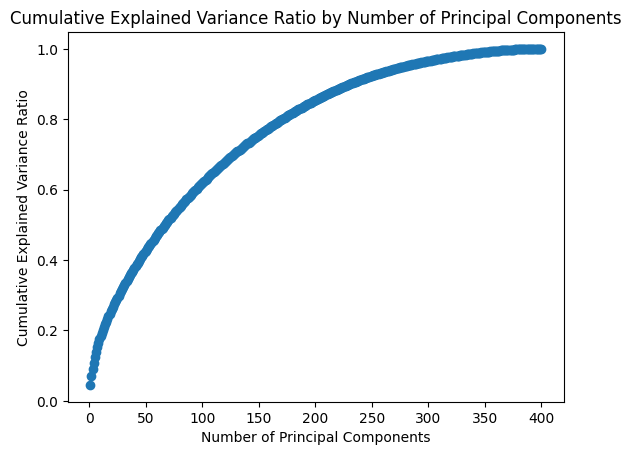

In [98]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Create a PCA object
pca = PCA()

# Fit the PCA on the training data
pca.fit(X_train)

# Calculate the cumulative explained variance ratio
cumulative_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance ratio
plt.plot(
    range(1, len(cumulative_explained_variance_ratio) + 1),
    cumulative_explained_variance_ratio,
    marker="o",
)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("Cumulative Explained Variance Ratio by Number of Principal Components")
plt.show()

Great! So let's keep the first 250 principal components because we see that they explain 90% of the variance.

In [99]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# Define the default number of components
n_components = 250

# Create the pipeline
pipeline = Pipeline(
    [
        (
            "pca",
            PCA(n_components=n_components),
        ),  # Specify the number of components for PCA
        ("rf", RandomForestClassifier(random_state=SEED)),  # Random Forest classifier
    ]
)

# Define the parameter grid for tuning
param_grid = {
    "pca__n_components": [100, 200, 250],  # Number of components for PCA
    "rf__n_estimators": [10, 50, 100, 200, 300],
    "rf__max_depth": [None, 5, 10],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4],
}

# Perform grid search to find the best parameters
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Train the best model on the training set
best_model.fit(X_train, y_train)

# Predict the target variable on the train and test sets
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculate the accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the best parameters and the accuracy scores
print("Best Parameters:", best_params)
print("Train Accuracy Score:", train_accuracy)
print("Test Accuracy Score:", test_accuracy)

# Print the classification report for the test set
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

Best Parameters: {'pca__n_components': 100, 'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 300}
Train Accuracy Score: 0.9983447134285123
Test Accuracy Score: 0.25453277545327757
Classification Report (Test Set):
              precision    recall  f1-score   support

         1.1       0.21      0.22      0.21       127
         1.2       0.29      0.52      0.37       122
         2.3       0.21      0.24      0.22       129
         2.4       0.17      0.15      0.16       142
         2.6       0.37      0.43      0.39       171
         3.1       0.11      0.08      0.09       131
         3.2       0.40      0.88      0.54       121
         3.3       0.10      0.05      0.07       147
         3.4       0.25      0.06      0.09       208
         3.9       0.10      0.09      0.09       136

    accuracy                           0.25      1434
   macro avg       0.22      0.27      0.23      1434
weighted avg       0.22      0.2

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Define the parameter grid for tuning
param_grid = {
    "n_estimators": [10, 25, 50],
    "max_depth": [None, 5, 10],
}

# Create the random forest classifier
rf = RandomForestClassifier(random_state=SEED)

# Perform grid search to find the best parameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Train the best model on the training set
best_model.fit(X_train, y_train)

# Predict the target variable on the train and test sets
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculate the accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the best parameters and the accuracy scores
print("Best Parameters:", best_params)
print("Train Accuracy Score:", train_accuracy)
print("Test Accuracy Score:", test_accuracy)

# Print the classification report for the test set
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

Best Parameters: {'max_depth': 10, 'n_estimators': 50}
Train Accuracy Score: 0.9615145872129113
Test Accuracy Score: 0.2594142259414226
Classification Report (Test Set):
              precision    recall  f1-score   support

         1.1       0.23      0.35      0.28       127
         1.2       0.29      0.42      0.34       122
         2.3       0.19      0.29      0.23       129
         2.4       0.16      0.13      0.14       142
         2.6       0.33      0.31      0.32       171
         3.1       0.14      0.08      0.10       131
         3.2       0.43      0.89      0.58       121
         3.3       0.14      0.10      0.11       147
         3.4       0.33      0.08      0.12       208
         3.9       0.16      0.14      0.15       136

    accuracy                           0.26      1434
   macro avg       0.24      0.28      0.24      1434
weighted avg       0.24      0.26      0.23      1434

